# Fine-tune ChatGPT-3.5 and GPT-4 with Weights & Biases

<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{openai-finetune-gpt35} -->

<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/openai/Fine_tune_GPT_3_with_Weights_&_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note:** you will need an [OpenAI API key](https://platform.openai.com/account/api-keys) to run this colab.

If you use OpenAI's API to [fine-tune ChatGPT-3.5](https://platform.openai.com/docs/guides/fine-tuning), you can now use the W&B integration to track experiments, models, and datasets in your central dashboard.

All it takes is one line: `openai wandb sync`

See the [OpenAI section](https://wandb.me/openai-docs) in the Weights & Biases documentation for full details of the integration

In [ ]:
!pip install -Uq openai tiktoken datasets tenacity wandb

In [ ]:
# Remove once this PR is merged: https://github.com/openai/openai-python/pull/590 and openai release is made
!pip uninstall -y openai -qq \
&& pip install git+https://github.com/morganmcg1/openai-python.git@update_wandb_logger -qqq

## Optional: Fine-tune ChatGPT-3.5

It's always more fun to experiment with your own projects so if you have already used the openai API to fine-tune an OpenAI model, just skip this section.

Otherwise let's fine-tune ChatGPT-3.5 on a legal dataset!

### Imports and initial set-up

In [ ]:
import openai
import wandb

import os
import json
import random
import tiktoken
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
from tenacity import retry, stop_after_attempt, wait_fixed

Start your Weigths & Biases run. If you don't have an account you can sign up for one for free at www.wandb.ai

In [ ]:
WANDB_PROJECT = "OpenAI-Fine-Tune"

### Set up your API key

In [ ]:
# # Enter credentials
openai_key = "YOUR_API_KEY"

openai.api_key = openai_key

### Dataset Preparation

We download a dataset from [LegalBench](https://hazyresearch.stanford.edu/legalbench/), a project to curate tasks for evaluating legal reasoning, specifically the [Contract NLI Explicit Identification task](https://github.com/HazyResearch/legalbench/tree/main/tasks/contract_nli_explicit_identification).

This comprises of a total of 117 examples, from which we will create our own train and test datasets

In [ ]:
from datasets import load_dataset

# Download the data, merge into a single dataset and shuffle
dataset = load_dataset("nguha/legalbench", "contract_nli_explicit_identification")

data = []
for d in dataset["train"]:
  data.append(d)

for d in dataset["test"]:
  data.append(d)

random.shuffle(data)

for idx, d in enumerate(data):
  d["new_index"] = idx

Let's look at a few samples.

In [ ]:
len(data), data[0:2]

(117,
 [{'answer': 'No',
   'index': '94',
   'text': 'Recipient shall use the Confidential Information exclusively for HySafe purposes, especially to advice the Governing Board of HySafe. ',
   'document_name': 'NDA_V3.pdf',
   'new_index': 0},
  {'answer': 'No',
   'index': '53',
   'text': '3. In consideration of each and every disclosure of CONFIDENTIAL INFORMATION, the Parties agree to: (c) make no disclosures of any CONFIDENTIAL INFORMATION to any party other than officers and employees of a Party to this IRA; (d) limit access to CONFIDENTIAL INFORMATION to those officers and employees having a reasonable need for such INFORMATION and being boUnd by a written obligation to maintain the confidentiality of such INFORMATION; and ',
   'document_name': '1084000_0001144204-06-046785_v056501_ex10-16.txt',
   'new_index': 1}])

### Format our Data for Chat Completion Models
We modify the `base_prompt` from the LegalBench task to make it a zero-shot prompt, as we are training the model instead of using few-shot prompting

In [ ]:
base_prompt_zero_shot = "Identify if the clause provides that all Confidential Information shall be expressly identified by the Disclosing Party. Answer with only `Yes` or `No`"

We now split it into training/validation dataset, lets train on 30 samples and test on the remainder


In [ ]:
n_train = 30
n_test = len(data) - n_train

In [ ]:
train_messages = []
test_messages = []

for d in data:
  prompts = []
  prompts.append({"role": "system", "content": base_prompt_zero_shot})
  prompts.append({"role": "user", "content": d["text"]})
  prompts.append({"role": "assistant", "content": d["answer"]})

  if int(d["new_index"]) < n_train:
    train_messages.append({'messages': prompts})
  else:
    test_messages.append({'messages': prompts})

len(train_messages), len(test_messages), n_test, train_messages[5]

(30,
 87,
 87,
 {'messages': [{'role': 'system',
    'content': 'Identify if the clause provides that all Confidential Information shall be expressly identified by the Disclosing Party. Answer with only `Yes` or `No`'},
   {'role': 'user',
    'content': '2. The Contractor shall not, without the State’s prior written consent, copy, disclose, publish, release, transfer, disseminate, use, or allow access for any purpose or in any form, any Confidential Information except for the sole and exclusive purpose of performing under the Contract.  '},
   {'role': 'assistant', 'content': 'No'}]})

### Save the data to Weigths & Biases

Save the data in a train and test file first

In [ ]:
train_file_path = 'encoded_train_data.jsonl'
with open(train_file_path, 'w') as file:
    for item in train_messages:
        line = json.dumps(item)
        file.write(line + '\n')

test_file_path = 'encoded_test_data.jsonl'
with open(test_file_path, 'w') as file:
    for item in test_messages:
        line = json.dumps(item)
        file.write(line + '\n')

Next, we validate that our training data is in the correct format using a script from the [OpenAI fine-tuning documentation](https://platform.openai.com/docs/guides/fine-tuning/)

In [ ]:
# Next, we specify the data path and open the JSONL file

def openai_validate_data(dataset_path):
  data_path = dataset_path

  # Load dataset
  with open(data_path) as f:
      dataset = [json.loads(line) for line in f]

  # We can inspect the data quickly by checking the number of examples and the first item

  # Initial dataset stats
  print("Num examples:", len(dataset))
  print("First example:")
  for message in dataset[0]["messages"]:
      print(message)

  # Now that we have a sense of the data, we need to go through all the different examples and check to make sure the formatting is correct and matches the Chat completions message structure

  # Format error checks
  format_errors = defaultdict(int)

  for ex in dataset:
      if not isinstance(ex, dict):
          format_errors["data_type"] += 1
          continue

      messages = ex.get("messages", None)
      if not messages:
          format_errors["missing_messages_list"] += 1
          continue

      for message in messages:
          if "role" not in message or "content" not in message:
              format_errors["message_missing_key"] += 1

          if any(k not in ("role", "content", "name") for k in message):
              format_errors["message_unrecognized_key"] += 1

          if message.get("role", None) not in ("system", "user", "assistant"):
              format_errors["unrecognized_role"] += 1

          content = message.get("content", None)
          if not content or not isinstance(content, str):
              format_errors["missing_content"] += 1

      if not any(message.get("role", None) == "assistant" for message in messages):
          format_errors["example_missing_assistant_message"] += 1

  if format_errors:
      print("Found errors:")
      for k, v in format_errors.items():
          print(f"{k}: {v}")
  else:
      print("No errors found")

  # Beyond the structure of the message, we also need to ensure that the length does not exceed the 4096 token limit.

  # Token counting functions
  encoding = tiktoken.get_encoding("cl100k_base")

  # not exact!
  # simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
  def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
      num_tokens = 0
      for message in messages:
          num_tokens += tokens_per_message
          for key, value in message.items():
              num_tokens += len(encoding.encode(value))
              if key == "name":
                  num_tokens += tokens_per_name
      num_tokens += 3
      return num_tokens

  def num_assistant_tokens_from_messages(messages):
      num_tokens = 0
      for message in messages:
          if message["role"] == "assistant":
              num_tokens += len(encoding.encode(message["content"]))
      return num_tokens

  def print_distribution(values, name):
      print(f"\n#### Distribution of {name}:")
      print(f"min / max: {min(values)}, {max(values)}")
      print(f"mean / median: {np.mean(values)}, {np.median(values)}")
      print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

  # Last, we can look at the results of the different formatting operations before proceeding with creating a fine-tuning job:

  # Warnings and tokens counts
  n_missing_system = 0
  n_missing_user = 0
  n_messages = []
  convo_lens = []
  assistant_message_lens = []

  for ex in dataset:
      messages = ex["messages"]
      if not any(message["role"] == "system" for message in messages):
          n_missing_system += 1
      if not any(message["role"] == "user" for message in messages):
          n_missing_user += 1
      n_messages.append(len(messages))
      convo_lens.append(num_tokens_from_messages(messages))
      assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

  print("Num examples missing system message:", n_missing_system)
  print("Num examples missing user message:", n_missing_user)
  print_distribution(n_messages, "num_messages_per_example")
  print_distribution(convo_lens, "num_total_tokens_per_example")
  print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
  n_too_long = sum(l > 4096 for l in convo_lens)
  print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

  # Pricing and default n_epochs estimate
  MAX_TOKENS_PER_EXAMPLE = 4096

  MIN_TARGET_EXAMPLES = 100
  MAX_TARGET_EXAMPLES = 25000
  TARGET_EPOCHS = 3
  MIN_EPOCHS = 1
  MAX_EPOCHS = 25

  n_epochs = TARGET_EPOCHS
  n_train_examples = len(dataset)
  if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
      n_epochs = min(MAX_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
  elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
      n_epochs = max(MIN_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

  n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
  print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
  print(f"By default, you'll train for {n_epochs} epochs on this dataset")
  print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
  print("See pricing page to estimate total costs")

Validate train data

In [ ]:
openai_validate_data(train_file_path)

Num examples: 30
First example:
{'role': 'system', 'content': 'Identify if the clause provides that all Confidential Information shall be expressly identified by the Disclosing Party. Answer with only `Yes` or `No`'}
{'role': 'user', 'content': 'Recipient shall use the Confidential Information exclusively for HySafe purposes, especially to advice the Governing Board of HySafe. '}
{'role': 'assistant', 'content': 'No'}
No errors found
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 69, 319
mean / median: 143.46666666666667, 122.0
p5 / p95: 82.10000000000001, 235.10000000000002

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 1
mean / median: 1.0, 1.0
p5 / p95: 1.0, 1.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning
Dataset has ~430

Log our data to Weigths & Biases Artifacts for storage and versioning

In [ ]:
wandb.init(
    project=WANDB_PROJECT,
    # entity="prompt-eng",
    job_type="log-data",
    config = {'n_train': n_train,
              'n_valid': n_test})

wandb.log_artifact(train_file_path,
                   "legalbench-contract_nli_explicit_identification-train",
                   type="train-data")

wandb.log_artifact(test_file_path,
                   "legalbench-contract_nli_explicit_identification-test",
                   type="test-data")

# keep entity (typically your wandb username) for reference of artifact later in this demo
entity = wandb.run.entity

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


### Create a fine-tuned model

We'll now use OpenAI API to fine-tune ChatGPT-3.5

Let's first download our training & validation files and save them to a folder called `my_data`. We will retrieve the `latest` version of the artifact, but it could also be `v0`, `v1` or any alias we associated with it

In [ ]:
wandb.init(project=WANDB_PROJECT,
          #  entity="prompt-eng",
           job_type="finetune")

artifact_train = wandb.use_artifact(
    f'{entity}/{WANDB_PROJECT}/legalbench-contract_nli_explicit_identification-train:latest',
    type='train-data')
train_file = artifact_train.get_path(train_file_path).download("my_data")

train_file

'my_data/encoded_train_data.jsonl'

Then we upload the training data to OpenAI. OpenAi has to process the data, so this will take a few minutes depending on the size of your dataset.

In [ ]:
openai_train_file_info = openai.File.create(
  file=open(train_file, "rb"),
  purpose='fine-tune'
)

# you may need to wait a couple of minutes for OpenAI to process the file
openai_train_file_info

<File file id=file-spPASR6VWco54SqfN2yo7T8v> JSON: {
  "object": "file",
  "id": "file-spPASR6VWco54SqfN2yo7T8v",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 24059,
  "created_at": 1693388388,
  "status": "uploaded",
  "status_details": null
}

### Time to train the model!

Let's define our ChatGPT-3.5 fine-tuning hyper-parameters.

In [ ]:
model = 'gpt-3.5-turbo'
n_epochs = 3

In [ ]:
openai_ft_job_info = openai.FineTuningJob.create(
    training_file=openai_train_file_info["id"],
    model=model,
    hyperparameters={"n_epochs": n_epochs}
)

ft_job_id = openai_ft_job_info["id"]

openai_ft_job_info

<FineTuningJob fine_tuning.job id=ftjob-x4tl83IlSGolkUF3fCFyZNGs> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-x4tl83IlSGolkUF3fCFyZNGs",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1693388447,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-WnF2wEqNkV1Nj65CzDxr6iUm",
  "result_files": [],
  "status": "created",
  "validation_file": null,
  "training_file": "file-spPASR6VWco54SqfN2yo7T8v",
  "hyperparameters": {
    "n_epochs": 3
  },
  "trained_tokens": null
}


> this takes around 5 minutes to train, and you get an email from OpenAI when finished.

**Thats it!**

Now your model is training on OpenAI's machines. To get the current state of your fine-tuning job, run:

In [ ]:
state = openai.FineTuningJob.retrieve(ft_job_id)
state["status"], state["trained_tokens"], state["finished_at"], state["fine_tuned_model"]

('succeeded',
 12732,
 1693389024,
 'ft:gpt-3.5-turbo-0613:weights-biases::7tC85HcX')

Show recent events for our fine-tuning job

In [ ]:
openai.FineTuningJob.list_events(id=ft_job_id, limit=5)

<OpenAIObject list> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-5x9Y6Payk6fIdyJyMRY5um1v",
      "created_at": 1693389024,
      "level": "info",
      "message": "Fine-tuning job successfully completed",
      "data": null,
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-i16NTGNakv9P0RkOtJ7vvvoG",
      "created_at": 1693389022,
      "level": "info",
      "message": "New fine-tuned model created: ft:gpt-3.5-turbo-0613:weights-biases::7tC85HcX",
      "data": null,
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-MkLrJQ8sDgaC67CdmFMwsIjV",
      "created_at": 1693389017,
      "level": "info",
      "message": "Step 90/90: training loss=0.00",
      "data": {
        "step": 90,
        "train_loss": 2.5828578600339824e-06,
        "train_mean_token_accuracy": 1.0
      },
      "type": "metrics"
    },
    {
      "objec

We can run a few different fine-tunes with different parameters or even with different datasets.

## Log OpenAI fine-tune jobs to Weights & Biases

We can log our fine-tunes with a simple command.

In [ ]:
!openai wandb sync --help

usage: openai wandb sync [-h] [-i ID] [-n N_FINE_TUNES] [--project PROJECT]
                         [--entity ENTITY] [--force] [--legacy]

options:
  -h, --help            show this help message and exit
  -i ID, --id ID        The id of the fine-tune job (optional)
  -n N_FINE_TUNES, --n_fine_tunes N_FINE_TUNES
                        Number of most recent fine-tunes to log when an id is
                        not provided. By default, every fine-tune is synced.
  --project PROJECT     Name of the Weights & Biases project where you're
                        sending runs. By default, it is "OpenAI-Fine-Tune".
  --entity ENTITY       Weights & Biases username or team name where you're
                        sending runs. By default, your default entity is used,
                        which is usually your username.
  --force               Forces logging and overwrite existing wandb run of the
                        same fine-tune.
  --legacy              Log results from legacy O

Calling `openai wandb sync` will log all un-synced fine-tuned jobs to W&B

Below we are just logging 1 job, passing:
- our OpenAI key as an environment variable
- the id of the fine-tune job we'd like to log
- the W&B project of where to log it to

See the [OpenAI section](https://wandb.me/openai-docs) in the Weights & Biases documentation for full details of the integration

In [ ]:
!OPENAI_API_KEY={openai_key} openai wandb sync --id {ft_job_id} --project {WANDB_PROJECT}

Retrieving fine-tune job...
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.9
wandb: Run data is saved locally in /Users/tcapelle/work/examples/colabs/openai/wandb/run-20230830_115915-ftjob-x4tl83IlSGolkUF3fCFyZNGs
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ftjob-x4tl83IlSGolkUF3fCFyZNGs
wandb: ⭐️ View project at https://wandb.ai/capecape/OpenAI-Fine-Tune
wandb: 🚀 View run at https://wandb.ai/capecape/OpenAI-Fine-Tune/runs/ftjob-x4tl83IlSGolkUF3fCFyZNGs
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb: train_accuracy ▁▁▁▁▁█▁█▁██▁████████████████████████████
wandb:     train_loss █▇▆▂▂▁▂▁▅▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: fine_tuned_model ft:gpt-3.5-turbo-061...
wandb:           status succeeded
wandb:   train_accuracy 1.0
wandb:       train_loss 0.0
wandb: 
wandb: 🚀 View run ftjob-x4tl83IlSGolkUF3fCFyZNGs at: 

In [ ]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
upload_file exception https://storage.googleapis.com/wandb-production.appspot.com/capecape/OpenAI-Fine-Tune/1ili9l51/requirements.txt?Expires=1693475972&GoogleAccessId=gorilla-files-url-signer-man%40wandb-production.iam.gserviceaccount.com&Signature=NzF9wj2gS8rMEwRT9wlft2lNubemw67f2qrz9Zy90Bjxg5xCL9pIu%2FRbBGjRwLA2v64PuiP23Au5Dho26Tnw3UjUS1apqTkaOgjWDTlCCiDLzvMUsqHf0lhhWIgGMZcsA4gPpOi%2Bc%2ByJm4z6JE7D6RJ7r8y4fI0Jg6fX9KSWpzh8INiM6fQZiQjUChLVdtNJQZ2gfu7xRc%2BZIUEjgDuUqmS705pIUOgJXA9MS3%2Fhewkc7CxWay4ReMJixBZgaqLIRqHQnyzb38I5nPrRS3JrwrigQyX6tOsK05LDLA0o%2Bs0K11664%2F1ZxO6mSTfOaw7tXUmbUUWFOp33Qq8KXNz9Zg%3D%3D: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
upload_file request headers: {'User-Agent': 'python-requests/2.28.2', 'Accept-Encoding': 'gzip

Our fine-tunes are now successfully synced to Weights & Biases.

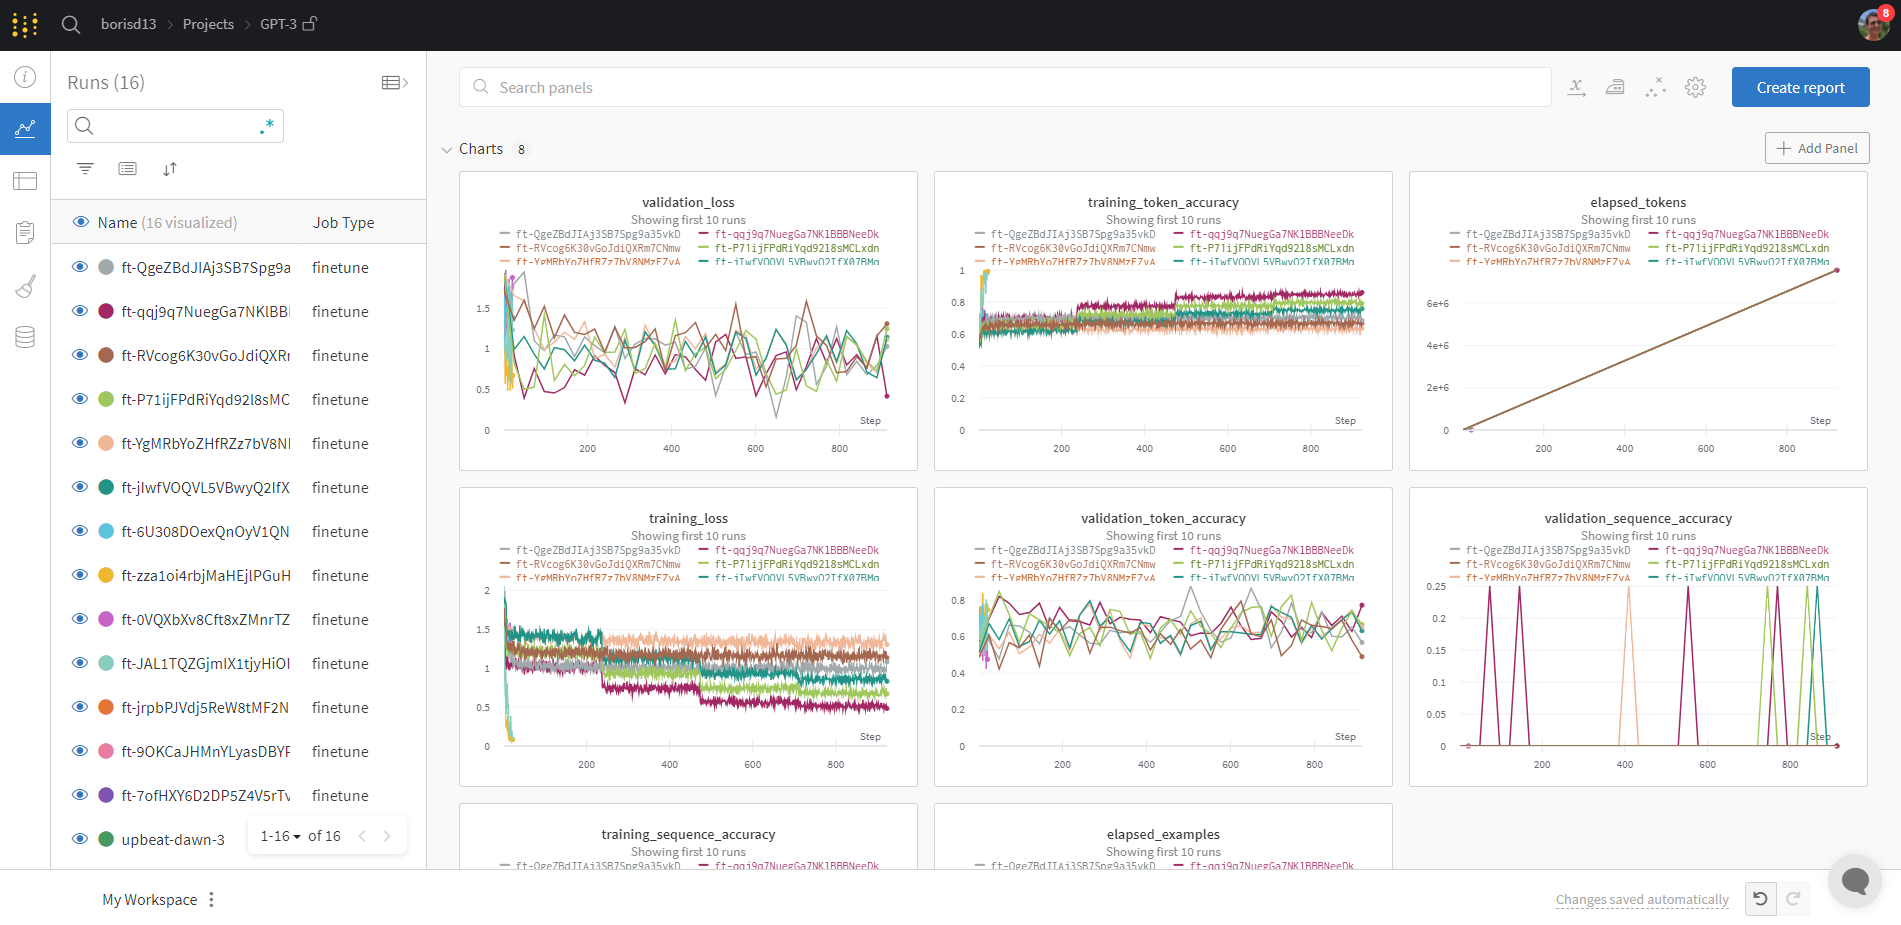

Anytime we have new fine-tunes, we can just call `openai wandb sync` to add them to our dashboard.

## Run evalution and log the results

The best way to evaluate a generative model is to explore sample predictions from your evaluation set.

Let's generate a few inference samples and log them to W&B and see how the performance compares to a baseline ChatGPT-3.5 model

In [ ]:
wandb.init(project=WANDB_PROJECT,
           job_type='eval')

artifact_valid = wandb.use_artifact(
    f'{entity}/{WANDB_PROJECT}/legalbench-contract_nli_explicit_identification-test:latest',
    type='test-data')
test_file = artifact_valid.get_path(test_file_path).download("my_data")

with open(test_file) as f:
    test_dataset = [json.loads(line) for line in f]

print(f"There are {len(test_dataset)} test examples")
wandb.config.update({"num_test_samples":len(test_dataset)})

There are 87 test examples


### Run evaluation on the Fine-Tuned Model
Set up OpenAI call with retries

In [ ]:
@retry(stop=stop_after_attempt(3), wait=wait_fixed(60))
def call_openai(messages="", model="gpt-3.5-turbo"):
  return openai.ChatCompletion.create(model=model, messages=messages, max_tokens=10)

Let's get our trained model id

In [ ]:
state = openai.FineTuningJob.retrieve(ft_job_id)
ft_model_id = state["fine_tuned_model"]
ft_model_id

'ft:gpt-3.5-turbo-0613:weights-biases::7tC85HcX'

Run evaluation and log results to W&B

In [ ]:
prediction_table = wandb.Table(columns=['messages', 'completion', 'target'])

eval_data = []

for row in tqdm(test_dataset):
    messages = row['messages'][:2]
    target = row["messages"][2]

    # res = call_openai(model=ft_model_id, messages=messages)
    res = openai.ChatCompletion.create(model=model, messages=messages, max_tokens=10)
    completion = res.choices[0].message.content

    eval_data.append([messages, completion, target])
    prediction_table.add_data(messages[1]['content'], completion, target["content"])

wandb.log({'predictions': prediction_table})

  0%|          | 0/87 [00:00<?, ?it/s]

Calculate the accuracy of the fine-tuned model and log to W&B



In [ ]:
correct = 0
for e in eval_data:
  if e[1].lower() == e[2]["content"].lower():
    correct+=1

accuracy = correct / len(eval_data)

print(f"Accuracy is {accuracy}")
wandb.log({"eval/accuracy": accuracy})
wandb.summary["eval/accuracy"] = accuracy

Accuracy is 0.8390804597701149


### Run evaluation on a Baseline model for comparison
Lets compare our model to the baseline model, `gpt-3.5-turbo`

In [ ]:
baseline_prediction_table = wandb.Table(columns=['messages', 'completion', 'target'])
baseline_eval_data = []

for row in tqdm(test_dataset):
    messages = row['messages'][:2]
    target = row["messages"][2]

    res = call_openai(model="gpt-3.5-turbo", messages=messages)
    completion = res.choices[0].message.content

    baseline_eval_data.append([messages, completion, target])
    baseline_prediction_table.add_data(messages[1]['content'], completion, target["content"])

wandb.log({'baseline_predictions': baseline_prediction_table})

  0%|          | 0/87 [00:00<?, ?it/s]

Calculate the accuracy of the fine-tuned model and log to W&B

In [ ]:
baseline_correct = 0
for e in baseline_eval_data:
  if e[1].lower() == e[2]["content"].lower():
    baseline_correct+=1

baseline_accuracy = baseline_correct / len(baseline_eval_data)
print(f"Baseline Accurcy is: {baseline_accuracy}")
wandb.log({"eval/baseline_accuracy": baseline_accuracy})
wandb.summary["eval/baseline_accuracy"] =  baseline_accuracy

Baseline Accurcy is: 0.7931034482758621


In [ ]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁
eval/baseline_accuracy,▁
eval/accuracy,0.83908
eval/baseline_accuracy,0.7931


And thats it! In this example we have prepared our data, logged it to Weights & Biases, fine-tuned an OpenAI model using that data, logged the results to Weights & Biases and then run evaluation on the fine-tuned model.

From here you can start to train on larger or more complex tasks, or else explore other ways to modify ChatGPT-3.5 such as giving it a different tone and style or response.


# Resources

* [OpenAI Fine-Tuning Guide](https://platform.openai.com/docs/guides/fine-tuning)
* [W&B Integration with OpenAI API Documentation](https://wandb.me/openai-docs)
* [W&B Report: GPT-3 exploration & fine-tuning tips](http://wandb.me/openai-report)